In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import gsw
import zarr
import gc
from tqdm import tqdm
from scipy.io import loadmat, savemat

import dask as da
from dask.diagnostics import ProgressBar

In [ ]:
def deconstruct(data_dir): 
    
    ### get data dimension 
    data = zarr.open_group(data_dir, mode='r')
    T = data['insituT']
    nz = T.shape[0]
    ny = T.shape[1]
    nx = T.shape[2]
    
    XC = data['lon'][:]
    YC = data['lat'][:]
    RC = data['depth'][:]
    
    res_S = []
    res_T = []
    res_p = []
    res_lon = []
    res_lat = []
    
    if XC.ndim == 1:
        no_mesh = True
    else:
        no_mesh = False
    
    for y in tqdm(range(ny)):
        for x in range(nx): 
            if np.isnan(data['insituT'][0,y,x]):
                continue
            else:
                for z in range(nz):
                    t = data['insituT'][z,y,x]
                    if ~np.isnan(t):
                        res_S.append(data['SALT'][z,y,x])
                        res_T.append(t)
                        res_p.append(abs(RC[z]))
                        
                        if no_mesh:
                            res_lon.append(XC[x])
                            res_lat.append(YC[y])
                        else:
                            res_lon.append(XC[y, x])
                            res_lat.append(YC[y, x])
                    else:
                        break

    return np.asarray(res_S), np.asarray(res_T), np.asarray(res_p), np.asarray(res_lat),np.asarray(res_lon)


In [ ]:
def reconstruct(data_dir, density_list):

    data = zarr.open_group(data_dir, mode='r')
    T = data['insituT']
    nz = T.shape[0]
    ny = T.shape[1]
    nx = T.shape[2]
    
    res = np.zeros((nz, ny, nx))
    count  = 0
    
    for y in tqdm(range(ny)):
        for x in range(nx): 
            if np.isnan(data['insituT'][0,y,x]):
                continue
            else:
                for z in range(nz):
                    t = data['insituT'][z,y,x]
                    if ~np.isnan(t):
                        res[z, y, x] = density_list[count]
                        count += 1
                    else:
                        break
                
    return res

In [2]:
def PARALLEL(index, data_dir, save_to, write=False):

    data = zarr.open_group(data_dir, mode='r')
    T = data['Temp_1-6']
    nz = T.shape[0]
    ny = T.shape[1]
    nx = T.shape[2]
    
    if data['Lon_1-6'].ndim == 1:
        mode =1
    else:
        mode =2
        
    if mode == 1:
        XC = data['Lon_1-6'][:]
        YC = data['Lat_1-6'][index]
    else:
        XC = data['Lon_1-6'][index, :]
        YC = data['Lat_1-6'][index, :]
        
    if write:
        outdata = np.zeros((nz, nx))
        
        data = zarr.open_group(data_dir, mode='a')
        write_data = loadmat(f"{save_to}/{index:03d}.mat")
        write_data = write_data['gamma'][:]
        try:
            write_data = write_data[0]
        except:
            pass
        count = 0
        G = data['gamma']
    
    RC = data['depth'][:]
    
    res_S = []
    res_T = []
    res_p = []
    res_lon = []
    res_lat = []
    
    mask = data['Temp_1-6'][0,index,:]
    T = data['Temp_1-6'][:,index,:]
    S = data['Salt_1-6'][:,index,:]
    
    for x in range(nx): 
        if np.isnan(mask[x]):
            continue
        else:
            for z in range(nz):
                if ~np.isnan(T[z,x]):
                    if not write:
                        res_S.append(S[z,x])
                        res_T.append(T[z,x])
                        res_p.append(abs(RC[z]))
                        if mode == 1:
                            res_lon.append(XC[x])
                            res_lat.append(YC)
                        else:
                            res_lon.append(XC[x])
                            res_lat.append(YC[x]) 
                            
                    elif write:
                        outdata[z, x] = write_data[count]
                        count +=1
                        
                else:
                    break
                        
    if not write:
        savemat(f'{save_to}/{index:03d}_S.mat', {'val':np.asarray(res_S)})
        savemat(f'{save_to}/{index:03d}_T.mat', {'val':np.asarray(res_T)})
        savemat(f'{save_to}/{index:03d}_P.mat', {'val':np.asarray(res_p)})
        savemat(f'{save_to}/{index:03d}_X.mat', {'val':np.asarray(res_lon)})
        savemat(f'{save_to}/{index:03d}_Y.mat', {'val':np.asarray(res_lat)})
    else:
        G[:, index, :] = outdata[:]

## SOhi

In [24]:
delayedObj = []

for i in tqdm(range(586)):
    delayedObj.append(da.delayed(PARALLEL)(index = i, 
                                           data_dir = '/Volumes/workDrive/temp/SOhi.zarr', 
                                           save_to = 'data/SOhi_Gamma_Inputs', 
                                           write=False))

100%|██████████████████████████████████████████████████████| 586/586 [00:00<00:00, 13780.50it/s]


In [25]:
ProgressBar().register()

In [15]:
na = da.compute(*delayedObj)

[########################################] | 100% Completed |  1min 55.4s


In [16]:
delayedObj = []

for i in tqdm(range(586)):
    delayedObj.append(da.delayed(PARALLEL)(index = i, 
                                           data_dir = '/Volumes/workDrive/temp/SOhi.zarr', 
                                           save_to = '/Volumes/workDrive/temp/SOhi_Gamma_Out', 
                                           write=True))

100%|██████████████████████████████████████████████████████| 586/586 [00:00<00:00, 14811.48it/s]


In [17]:
na = da.compute(*delayedObj)

[########################################] | 100% Completed |  1min 55.7s


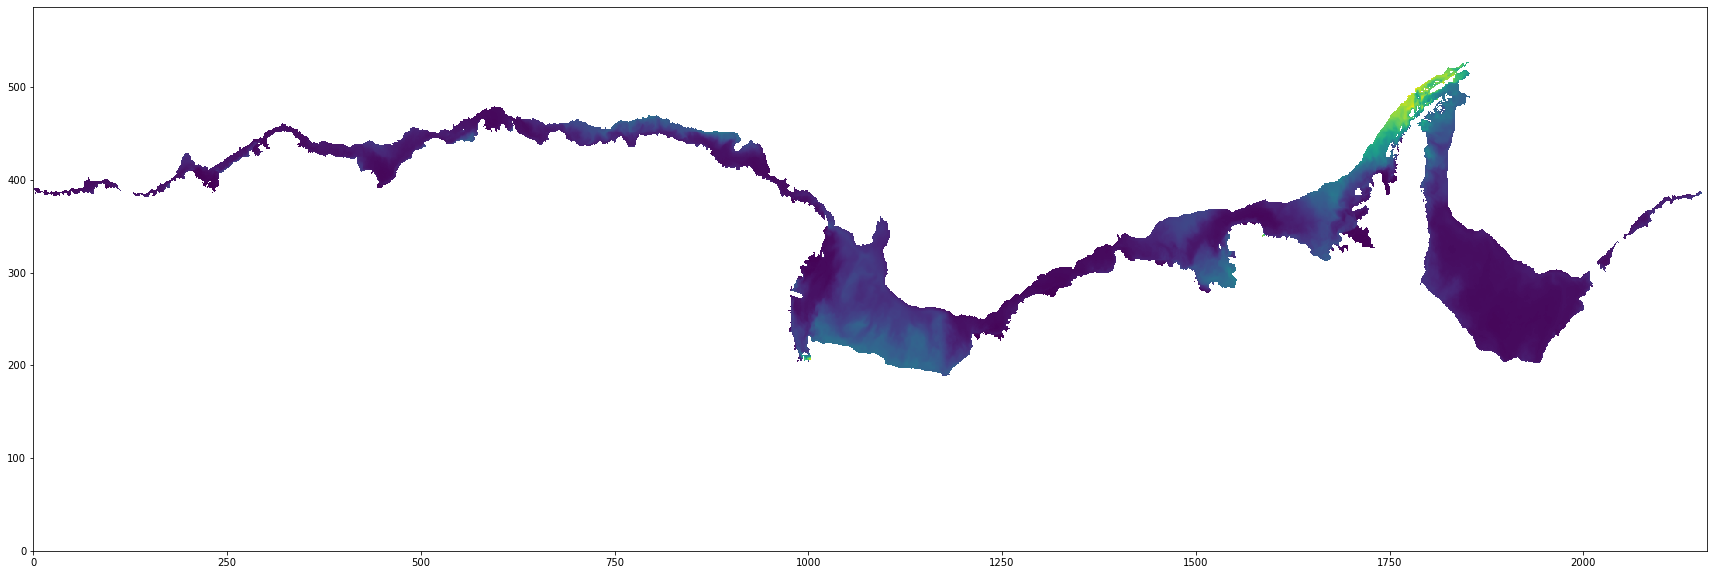

In [18]:
data = zarr.open('/Volumes/workDrive/temp/SOhi.zarr', mode='r')
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(data['Temp_1-6'][0,:,:])

# LLC4320

In [6]:
delayedObj = []

for i in tqdm(range(563)):
    delayedObj.append(da.delayed(PARALLEL)(index = i, 
                                           data_dir = '/Volumes/workDrive/temp/LLC4320.zarr', 
                                           save_to = '/Volumes/workDrive/temp/LLC_Gamma_In', 
                                           write=False))

100%|██████████████████████████████████████████████████████| 563/563 [00:00<00:00, 15546.43it/s]


In [7]:
ProgressBar().register()

In [8]:
na = da.compute(*delayedObj)

[########################################] | 100% Completed | 47.4s
[########################################] | 100% Completed | 47.4s


In [11]:
delayedObj = []

for i in tqdm(range(563)):
    delayedObj.append(da.delayed(PARALLEL)(index = i, 
                                           data_dir = '/Volumes/workDrive/temp/LLC4320.zarr', 
                                           save_to = '/Volumes/workDrive/temp/LLC_Gamma_Out', 
                                           write=True))

100%|██████████████████████████████████████████████████████| 563/563 [00:00<00:00, 12986.68it/s]


In [12]:
na = da.compute(*delayedObj)

[########################################] | 100% Completed | 45.4s
[########################################] | 100% Completed | 45.5s


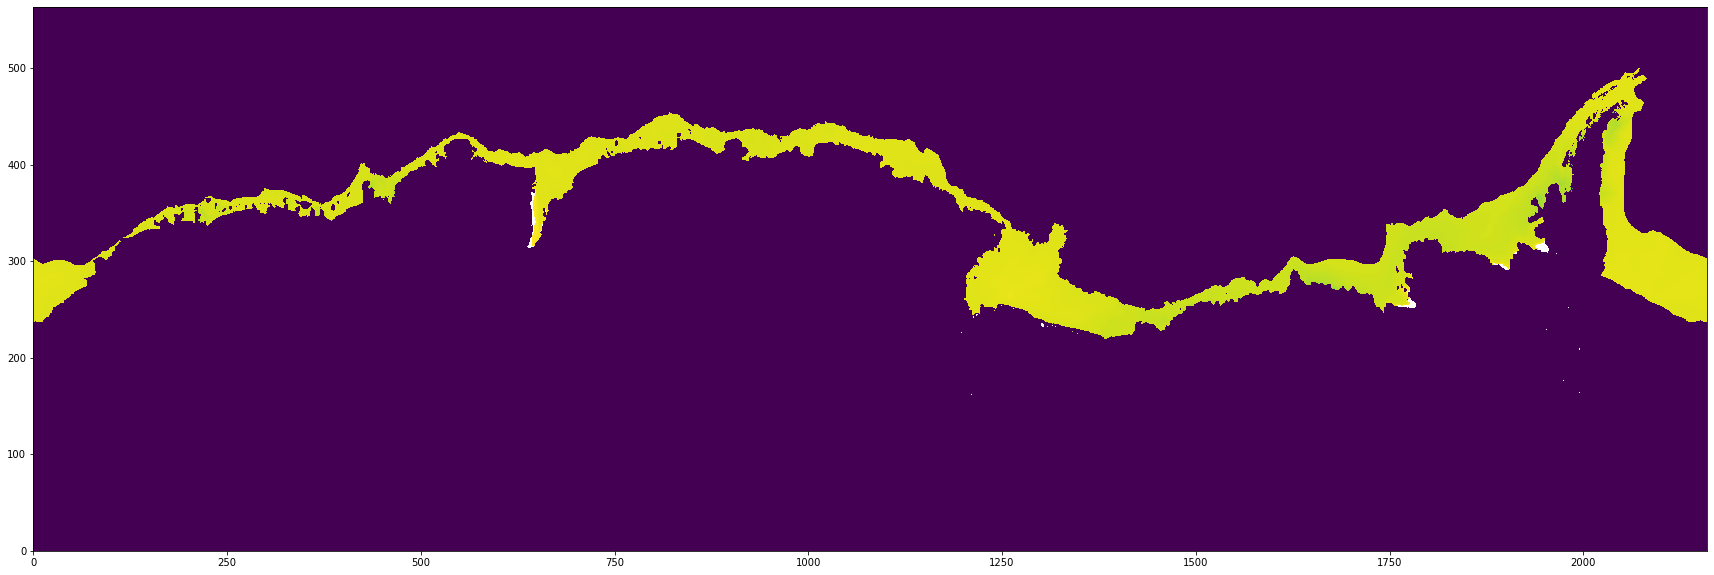

In [13]:
data = zarr.open('/Volumes/workDrive/temp/LLC4320.zarr', mode='r')
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(data['gamma'][0,:,:])

# SOSE

In [11]:
S, T, p, lat, lon = deconstruct('data/SOSE.zarr')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [06:52<00:00,  2.99s/it]


In [16]:
savemat('data/SOSE_gamma_inputs/S.mat', {'S':S})
savemat('data/SOSE_gamma_inputs/T.mat', {'T':T})
savemat('data/SOSE_gamma_inputs/p.mat', {'p':p})
savemat('data/SOSE_gamma_inputs/lat.mat', {'lat':lat})
savemat('data/SOSE_gamma_inputs/lon.mat', {'lon':lon})

In [18]:
neutral_density = loadmat('data/SOSE_Neutral_Density.mat')
neutral_density = neutral_density['gamma']
neutral_density = np.squeeze(neutral_density)

In [28]:
SOSE_gamma = reconstruct('data/SOSE.zarr', neutral_density)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [04:59<00:00,  2.17s/it]


In [32]:
dataset = zarr.open('data/SOSE.zarr', mode='a')
dataset['gamma'] = SOSE_gamma[:]

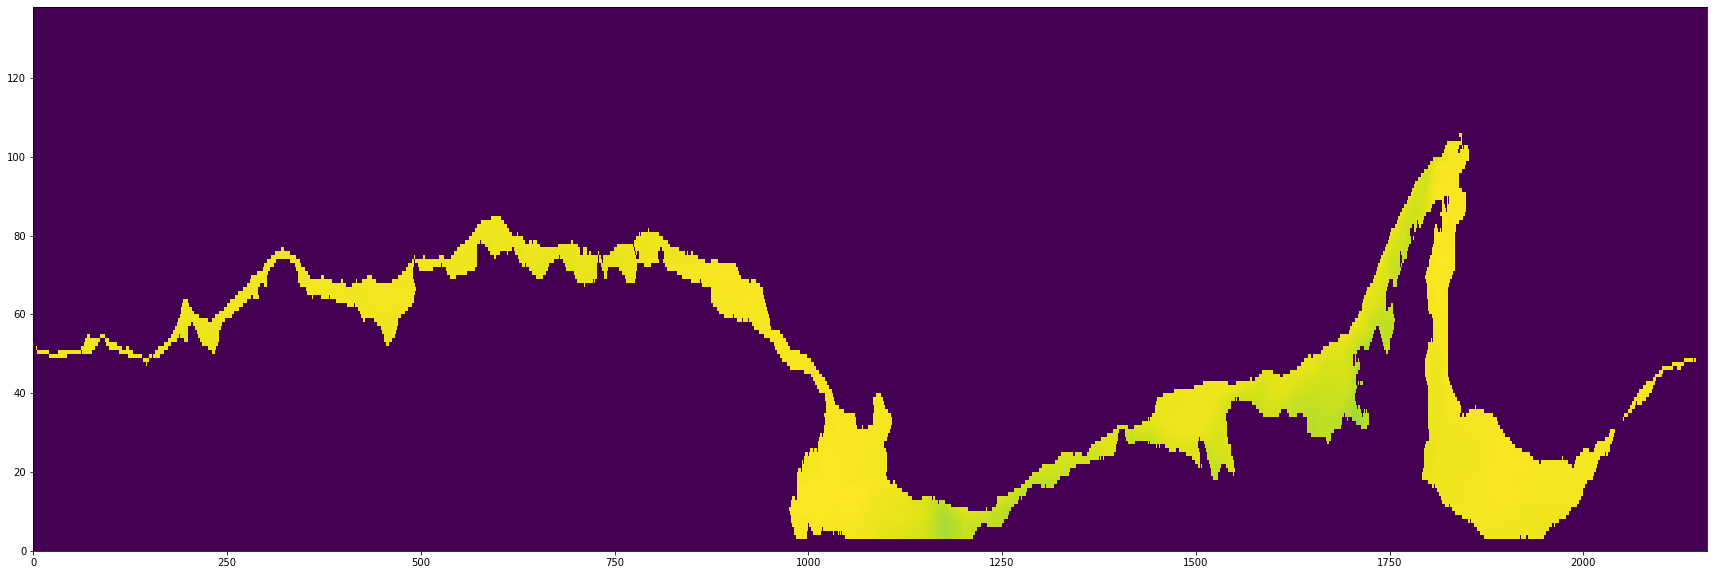

In [36]:
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(dataset['gamma'][0,:,:])


# ECCO

In [3]:
S, T, p, lat, lon = deconstruct('data/ECCO.zarr')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:23<00:00,  3.86it/s]


In [4]:
savemat('data/ECCO_gamma_inputs/S.mat', {'S':S})
savemat('data/ECCO_gamma_inputs/T.mat', {'T':T})
savemat('data/ECCO_gamma_inputs/p.mat', {'p':p})
savemat('data/ECCO_gamma_inputs/lat.mat', {'lat':lat})
savemat('data/ECCO_gamma_inputs/lon.mat', {'lon':lon})

In [5]:
neutral_density = loadmat('data/ECCO_Neutral_Density.mat')
neutral_density = neutral_density['gamma']
neutral_density = np.squeeze(neutral_density)

In [6]:
SOSE_gamma = reconstruct('data/ECCO.zarr', neutral_density)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:14<00:00,  6.24it/s]


In [7]:
dataset = zarr.open('data/ECCO.zarr', mode='a')
dataset['gamma'] = SOSE_gamma[:]

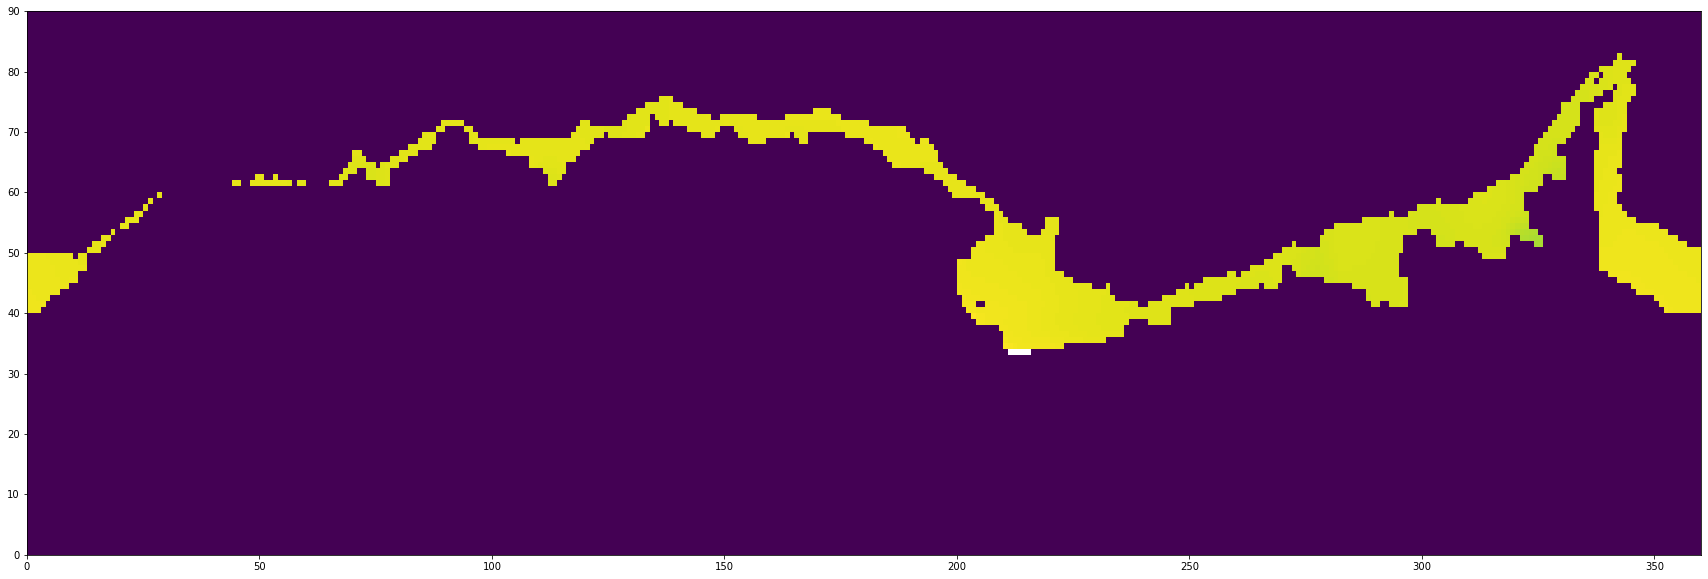

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
ax.pcolormesh(dataset['gamma'][0,:,:])